# PreAnalysis and Reading the Dataset

In [12]:
#Import the modules required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import itertools
import pdb

In [13]:
#Name the headers of the data and read the file
colName = ['lettr','x-box','ybox','width','high','onpix','x-bar','y-bar','x2bar','y2bar','xybar','x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx'];
data = pd.read_csv('letter-recognition.data',header = None, names = colName);

In [14]:
#Check how the dataset looks like
data.head()

,lettr,x-box,ybox,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [15]:
#Size of the data
data.shape

(20000, 17)

In [16]:
#Check for missing values
pd.isnull(data).sum()

lettr    0
x-box    0
ybox     0
width    0
high     0
onpix    0
x-bar    0
y-bar    0
x2bar    0
y2bar    0
xybar    0
x2ybr    0
xy2br    0
x-ege    0
xegvy    0
y-ege    0
yegvx    0
dtype: int64

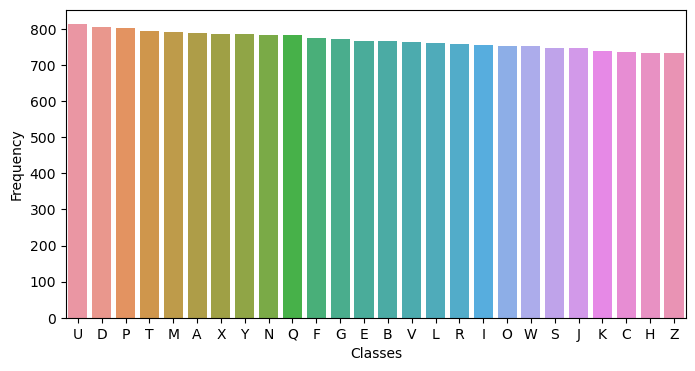

In [17]:
#Check whether the classes are balanced or not
plt.subplots(figsize=(8,4))
sns.barplot(x = data['lettr'].value_counts().index, y = data['lettr'].value_counts().values);
plt.xlabel('Classes');
plt.ylabel('Frequency');

In [18]:
#Function that divides the data into training and test randomly
def Preprocessing(df):
    labels_train = pd.DataFrame();
    features_train = pd.DataFrame();
    labels_test = pd.DataFrame();
    features_test = pd.DataFrame();
    #Seperate features and labels of each class
    for i in range(26):
        labels_class = df.lettr[df['lettr'] == chr(ord('A') + i)];
        features_class = df[df['lettr'] == chr(ord('A') + i)].drop(['lettr'], axis = 1);
        index = np.random.permutation(len(labels_class)); #Random Indexes to divide the dataset into train and test
        labels_train = pd.concat([labels_train, labels_class.iloc[index[0:650:1]]]);
        features_train = pd.concat([features_train, features_class.iloc[index[0:650:1]]]);
        labels_test = pd.concat([labels_test, labels_class.iloc[index[650:len(labels_class)]]]);
        features_test = pd.concat([features_test, features_class.iloc[index[650:len(labels_class)]]]);
    #Shuffle the training data
    shuff = np.random.permutation(len(labels_train));
    labels_train = labels_train.iloc[shuff];
    features_train = features_train.iloc[shuff];
    #Shuffle the test data
    shuff = np.random.permutation(len(labels_test));
    labels_test = labels_test.iloc[shuff];
    features_test = features_test.iloc[shuff];

    return labels_train, features_train, labels_test, features_test;

In [19]:
labels_train, features_train, labels_test, features_test = Preprocessing(data);
labels_train.columns = ['lettr'];
labels_test.columns = ['lettr'];

In [20]:
#Normalize the features matrices for Neural Networks and logistic regression
features_train = features_train/15
features_test = features_test/15

In [21]:
def softmax(ar):
    exps = np.exp(ar)
    denom = sum(exps)
    softmax = exps/denom
    return softmax

# Logistic Regression as Neural Network is indeed the simplest Neural Network with NO HIDDEN LAYERS.

In [22]:
#Implementation of Logistic regression using neural networks with SGD + momentum

#Initalize weight and bias using Xaviers Initialization
#Source:https://mnsgrg.com/2017/12/21/xavier-initialization/
b = -np.sqrt(6/(16+26)) + 2*np.sqrt(6/(16+26))*np.random.uniform(size = (26,1))
w = -np.sqrt(6/(16+26)) + 2*np.sqrt(6/(16+26))*np.random.uniform(size = (26,16))

#Initialize Variables
epoch = 50
lr = 0.05
alp = 0.35
lbl = np.zeros((26,1))
err = np.zeros((epoch,1))
acc = np.zeros((epoch,1))
db = np.zeros((26,1))   #Gradient for bias
dw = np.zeros((26,16))  #Gradient for weight

#Temp variables to save best parameters
min_err = np.Inf
max_acc = 0
bpred = np.zeros((len(labels_test),1))

for i in range(epoch):
    shuff = np.random.permutation(len(labels_train))
    #Pass over an epoch
    for j in range(len(labels_train)):
        cls = labels_train.iloc[shuff[j]]
        lbl[ord(cls[0]) - 65] = 1    #One hot encoding

        #Forward Pass
        f = np.reshape(np.array(features_train.iloc[shuff[j]]),(16,1)) #Feature needs to be reshaped due to numpy default behaviour
        tot = np.matmul(w,f) + b
        o = softmax(tot)
        
        #Backward Pass
        db = alp*db + lr*(o-lbl)
        dw = alp*dw + lr*np.matmul((o-lbl),np.transpose(f))
        b = b - db
        w = w - dw

        lbl[:] = 0
    
    #Check performance on test set
    for k in range(len(labels_test)):
        cls = labels_test.iloc[k]
        lbl[ord(cls[0]) - 65] = 1
        f = np.reshape(np.array(features_test.iloc[k]),(16,1))
        tot = np.matmul(w,f) + b
        o = softmax(tot)

        maxIdx = np.argmax(o)
        pred[k] = chr(ord('A') + maxIdx)

        if pred[k] == cls[0]:
            acc[i] = acc[i] + 1

        entropy = -lbl*np.log(o)
        entropy = np.nan_to_num(entropy)
        err[i] = err[i] + np.sum(entropy)
        lbl[:] = 0
    
    #print('Epoch:', i, 'Accuracy:', acc[i]/len(labels_test)*100, 'Cross Entropy Error:', err[i]/len(labels_test))
    #Minimum Error 
    if (err[i] < min_err):
        min_err = err[i]
        bpred = pred
        
    #Set gradient and labels back to zero
    lbl[:] = 0
    db[:] = 0
    dw[:] = 0        

In [23]:
print('Best Accuracy achieved:',np.around(np.max(acc)/len(labels_test)*100,decimals=3)) 

Best Accuracy achieved: 51.065


In [24]:
cnf = confusion_matrix(labels_test, bpred);cnf

array([[118,   0,   0,   2,   0,   0,   0,   0,   0,   3,   0,   0,   0,
          0,   0,   0,   0,   0,   9,   0,   1,   0,   3,   2,   1,   0],
       [  0,   0,   0,  12,   0,   0,   0,   0,   0,   9,   0,   0,   0,
          0,   0,   0,   5,   0,  89,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0,  62,   0,   0,   1,   0,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   3,   0,   8,   0,   9,   0,   2,   0,   0,   0],
       [  2,   0,   0,  97,   0,   1,   0,   0,   0,  28,   0,   0,   0,
          1,   0,   0,   0,   0,  20,   0,   6,   0,   0,   0,   0,   0],
       [  0,   0,  31,   0,   0,   6,   0,   0,   1,  12,   0,   0,   0,
          0,   0,   0,   6,   0,  43,   0,   2,   0,   0,  11,   0,   6],
       [  0,   0,   0,   3,   0,  96,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   2,   1,   0,  17,   1,   1,   0,   2,   1,   0,   0],
       [  1,   0,  27,   1,   0,   1,   1,   0,   0,   2,   0,   0,   2,
          0,   0,   0,  32,   0,  34,   0,  1

Text(0, 0.5, 'Cross Entropy Error')

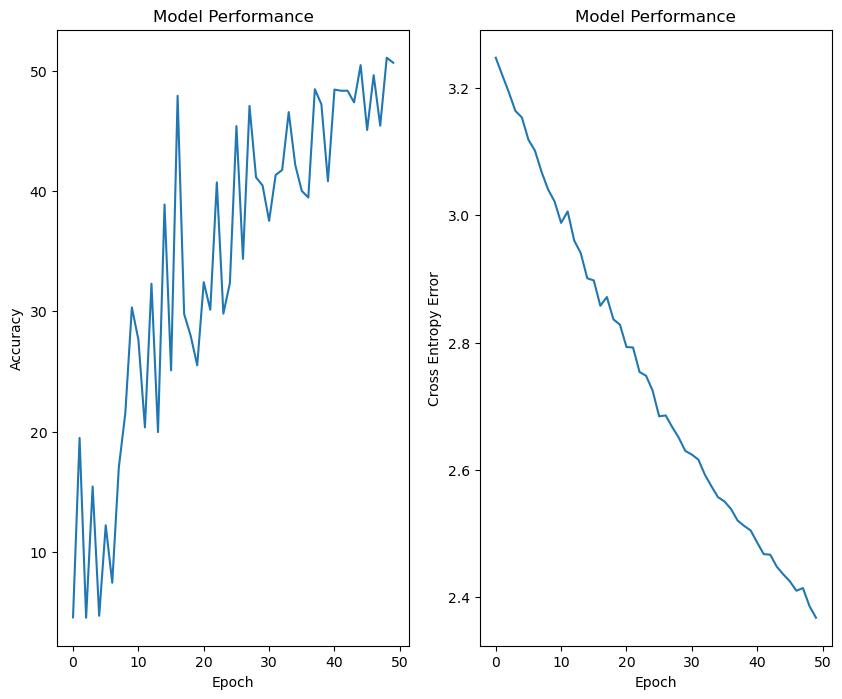

In [28]:
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.plot(np.arange(50),acc/len(labels_test)*100)
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(122)
plt.plot(np.arange(50),err/len(labels_test))
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Error')

# The results from no a NN with no hidden layers is not interesting. So we go into a deeper learning method.

# One Layer Neural Network

In [29]:
#Implementation of One layer neural networks with SGD + momentum

#Initalize weight and bias using Xaviers Initialization
#Source:https://mnsgrg.com/2017/12/21/xavier-initialization/
hn = 30 #Number of hidden neurons
b1 = -np.sqrt(6/(16+hn)) + 2*np.sqrt(6/(16+hn))*np.random.uniform(size = (hn,1))
w1 = -np.sqrt(6/(16+hn)) + 2*np.sqrt(6/(16+hn))*np.random.uniform(size = (hn,16))
b2 = -np.sqrt(6/(26+hn)) + 2*np.sqrt(6/(26+hn))*np.random.uniform(size = (26,1))
w2 = -np.sqrt(6/(26+hn)) + 2*np.sqrt(6/(26+hn))*np.random.uniform(size = (26,hn))

#Initialize Variables
epoch = 100
lr = 0.1
alp = 0.2
lbl = np.zeros((26,1))
err = np.zeros((epoch,1))
acc = np.zeros((epoch,1))
db1 = np.zeros((hn,1))   #Gradient for bias
dw1 = np.zeros((hn,16))  #Gradient for weight
db2 = np.zeros((26,1))
dw2 = np.zeros((26,hn))

#Temp variables to save best parameters
min_err = np.Inf
max_acc = 0
bpred = np.zeros((len(labels_test),1))

for i in range(epoch):
    shuff = np.random.permutation(len(labels_train))
    #Pass over an epoch
    for j in range(len(labels_train)):
        cls = labels_train.iloc[shuff[j]]
        lbl[ord(cls[0]) - 65] = 1    #One hot encoding

        #Forward Pass
        f = np.reshape(np.array(features_train.iloc[shuff[j]]),(16,1)) #Feature needs to be reshaped due to numpy default behaviour
        l1 = np.matmul(w1,f) + b1
        o1 = 1/(1 + np.exp(-l1)) #Sigmoid
        tot = np.matmul(w2,o1) + b2
        o = softmax(tot)

        #Backward Pass (Might be a little confusing, so try doing the steps on a small matrix)
        db2 = alp*db2 + lr*(o-lbl)
        dw2 = alp*dw2+ lr*np.matmul((o-lbl),np.transpose(o1))
        db1 = alp*db1 + np.transpose(lr*np.matmul(np.transpose(o-lbl),w2))*o1*(1-o1)
        dw1 = alp*dw1 + np.matmul((np.transpose(lr*np.matmul(np.transpose(o-lbl),w2))*o1*(1-o1)),np.transpose(f))

        b1 = b1 - db1
        w1 = w1 - dw1
        b2 = b2 - db2
        w2 = w2 - dw2

        lbl[:] = 0
    
    #Check performance on test set
    for k in range(len(labels_test)):
        cls = labels_test.iloc[k]
        lbl[ord(cls[0]) - 65] = 1
        f = np.reshape(np.array(features_test.iloc[k]),(16,1))

        l1 = np.matmul(w1,f) + b1
        o1 = 1/(1 + np.exp(-l1)) #Sigmoid
        tot = np.matmul(w2,o1) + b2
        o = softmax(tot)

        maxIdx = np.argmax(o)
        pred[k] = chr(ord('A') + maxIdx)
        
        if pred[k] == cls[0]:
            acc[i] = acc[i] + 1

        entropy = -lbl*np.log(o)
        entropy = np.nan_to_num(entropy)
        err[i] = err[i] + np.sum(entropy)
        lbl[:] = 0

    #print('Epoch:', i, 'Accuracy:', acc[i]/len(labels_test)*100, 'Cross Entropy Error:', err[i]/len(labels_test))
    #Early Stopping condition
    if (err[i] < min_err):
        min_err = err[i]
        bpred = pred

    #Set gradient and labels back to zero
    lbl[:] = 0
    db1[:] = 0
    dw1[:] = 0
    db2[:] = 0
    dw2[:] = 0        

In [30]:
print('Best Accuracy achieved:',np.around(np.max(acc)/len(labels_test)*100,decimals=3)) 

Best Accuracy achieved: 75.387


In [31]:
cnf = confusion_matrix(labels_test, bpred);cnf

array([[122,   0,   0,   0,   0,   0,   0,   1,   0,   2,   0,   0,   0,
          1,   1,   1,   6,   0,   0,   1,   1,   1,   0,   1,   1,   0],
       [  0,  75,   0,   1,   1,   0,   1,   5,   2,   0,   0,   0,   0,
          0,   1,   5,   7,   8,   8,   0,   0,   0,   0,   2,   0,   0],
       [  0,   0,  71,   0,   5,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   3,   0,   3,   0,   1,   0,   0,   2,   0,   0,   0,   1],
       [  1,   2,   0, 109,   0,   0,   0,   3,   0,   3,   0,   0,   1,
          2,  13,   8,   2,   3,   0,   0,   0,   0,   0,   5,   0,   3],
       [  0,   0,   1,   0,  91,   1,   0,   0,   0,   0,   1,   0,   0,
          0,   0,   0,   5,   0,   3,   0,   0,   0,   0,   3,   0,  13],
       [  0,   2,   2,   3,   2,  78,   0,   1,   1,   2,   0,   0,   0,
          0,   0,  21,   4,   0,   2,   4,   0,   0,   0,   2,   0,   1],
       [  0,   1,  37,   1,   1,   1,  26,   2,   0,   0,   0,   0,   0,
          0,   8,   0,  42,   1,   3,   0,   

Text(0, 0.5, 'Cross Entropy Error')

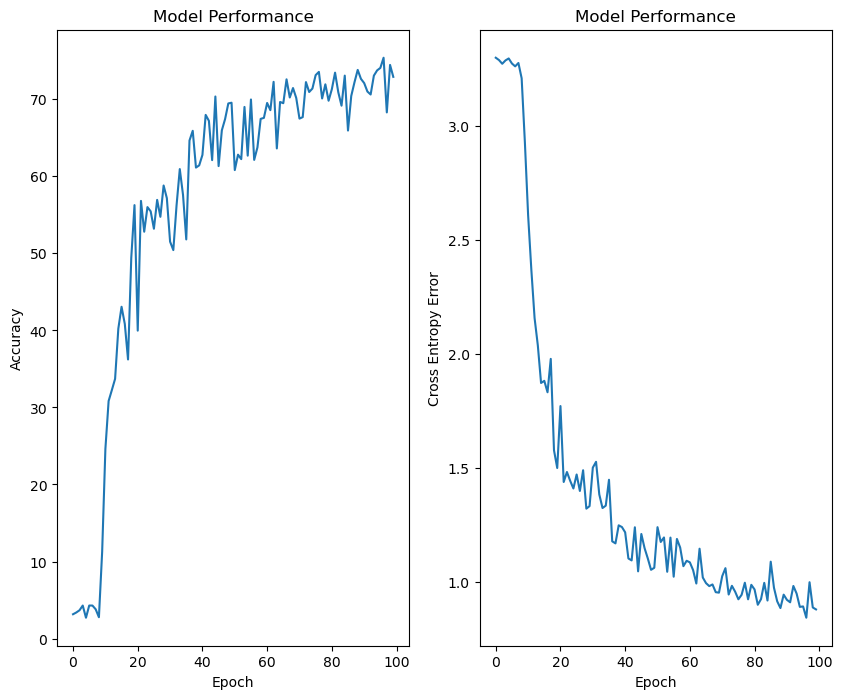

In [33]:
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.plot(np.arange(100),acc/len(labels_test)*100)
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(122)
plt.plot(np.arange(100),err/len(labels_test))
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Error')

# The results from 1 Layer Neural Network seems promising however we need to go further to find better results.

# 2 Layers Neural Network

In [23]:
#  TO PERFORME PROPERLY, WE NEED FIRST TO HAVE A DEFINITION OF PRED-FUNCTION THEN IT WILL BE MODIFIED IN 2-LAYERS NN. 
#  IT WAS A LONG-STANDING ERROR IN THE CODE WHICH SEEMS TO BE SOLVED THIS WAY. YET, LET'S SAY, DO NOT TOUCH THE CODE THAT WORKS.
# THAT'S ALL I CAN ARGUE HERE!

#Naive Bayes Models

#Find the prior probability of each class
prior = np.zeros((26,1));

for i in range(26):
    prior[i] = (labels_train == chr(ord('A') + i)).sum()/len(labels_train);

#Seperate the features of each class and find the probability matrix(each feature)
likelihood = np.zeros((26,16));

for i in range(26):
    tidx = labels_train == chr(ord('A') + i);
    temp = features_train[tidx.values];
    likelihood[i,:] = (1 + np.sum(temp,axis = 0))/np.sum(temp).sum();
    
#Classify using Multinomial Naivee Bayes
prob = np.zeros((26,1));
pred = np.ndarray(shape=(len(labels_test),1), dtype=object);

for i in range(len(labels_test)):
    for j in range(26):
        prob[j] = np.log(prior[j]) + np.sum(np.log(likelihood[j,:])*features_test.iloc[i])
    maxIndex = np.argmax(prob);
    pred[i] = chr(ord('A') + maxIndex);

In [24]:
#Implementation of 2-layer neural networks with SGD + momentum

#Initalize weight and bias using Xaviers Initialization
#Source:https://mnsgrg.com/2017/12/21/xavier-initialization/
hn1 = 64 #Number of hidden neurons in layer 1
hn2 = 32 #Number of hidden neurons in layer 2
b1 = -np.sqrt(6/(16+hn1)) + 2*np.sqrt(6/(16+hn1))*np.random.uniform(size = (hn1,1))
w1 = -np.sqrt(6/(16+hn1)) + 2*np.sqrt(6/(16+hn1))*np.random.uniform(size = (hn1,16))
b2 = -np.sqrt(6/(hn1+hn2)) + 2*np.sqrt(6/(hn1+hn2))*np.random.uniform(size = (hn2,1))
w2 = -np.sqrt(6/(hn1+hn2)) + 2*np.sqrt(6/(hn1+hn2))*np.random.uniform(size = (hn2,hn1))
b3 = -np.sqrt(6/(26+hn2)) + 2*np.sqrt(6/(26+hn2))*np.random.uniform(size = (26,1))
w3 = -np.sqrt(6/(26+hn2)) + 2*np.sqrt(6/(26+hn2))*np.random.uniform(size = (26,hn2))


#Initialize Variables
epoch = 100
lr = 0.09
alp = 0.008
lbl = np.zeros((26,1))
err = np.zeros((epoch,1))
acc = np.zeros((epoch,1))
db1 = np.zeros((hn1,1))   #Gradient for bias
dw1 = np.zeros((hn1,16))  #Gradient for weight
db2 = np.zeros((hn2,1))
dw2 = np.zeros((hn2,hn1))
db3 = np.zeros((26,1))
dw3 = np.zeros((26,hn2))

#Temp variables to save best parameters
min_err = np.Inf
max_acc = 0
bpred = np.zeros((len(labels_test),1))

for i in range(epoch):
    shuff = np.random.permutation(len(labels_train))
    #Pass over an epoch
    for j in range(len(labels_train)):
        cls = labels_train.iloc[shuff[j]]
        lbl[ord(cls[0]) - 65] = 1    #One hot encoding

        #Forward Pass
        f = np.reshape(np.array(features_train.iloc[shuff[j]]),(16,1)) #Feature needs to be reshaped due to numpy default behaviour
        l1 = np.matmul(w1,f) + b1
        o1 = 1/(1 + np.exp(-l1)) #Sigmoid
        l2 = np.matmul(w2,o1) + b2
        o2 = 1/(1 + np.exp(-l2))
        tot = np.matmul(w3,o2) + b3
        o = softmax(tot)

        #Backward Pass (Might be a little confusing, so try doing the steps on a small matrix)
        #pdb.set_trace()
        db3 = alp*db3 + lr*(o-lbl)
        dw3 = alp*db3 + lr*np.matmul((o-lbl),np.transpose(o2))
        db2 = alp*db2 + np.transpose(lr*np.matmul(np.transpose(o-lbl),w3))*o2*(1-o2)
        dw2 = alp*dw2 + np.transpose(lr*np.matmul(np.transpose(o-lbl),w3))*o2*(1-o2)*np.transpose(o1)
        db1 = alp*db1 + np.transpose(np.matmul(np.transpose(np.transpose(lr*np.matmul(np.transpose(o-lbl),w3))*o2*(1-o2)),w2))*o1*(1-o1)
        dw1 = alp*dw1 + np.matmul(np.transpose(np.matmul(np.transpose(np.transpose(lr*np.matmul(np.transpose(o-lbl),w3))*o2*(1-o2)),w2))*o1*(1-o1),np.transpose(f))

        b1 = b1 - db1
        w1 = w1 - dw1
        b2 = b2 - db2
        w2 = w2 - dw2
        b3 = b3 - db3
        w3 = w3 - dw3

        lbl[:] = 0
    
    #Check performance on test set
    for k in range(len(labels_test)):
        cls = labels_test.iloc[k]
        lbl[ord(cls[0]) - 65] = 1
        f = np.reshape(np.array(features_test.iloc[k]),(16,1))

        l1 = np.matmul(w1,f) + b1
        o1 = 1/(1 + np.exp(-l1)) #Sigmoid
        l2 = np.matmul(w2,o1) + b2
        o2 = 1/(1 + np.exp(-l2))
        tot = np.matmul(w3,o2) + b3
        o = softmax(tot)

        maxIdx = np.argmax(o)
        pred[k] = chr(ord('A') + maxIdx)

        if pred[k] == cls[0]:
            acc[i] = acc[i] + 1

        entropy = -lbl*np.log(o)
        entropy = np.nan_to_num(entropy)
        err[i] = err[i] + np.sum(entropy)
        lbl[:] = 0

    #pdb.set_trace()
    #print('Epoch:', i, 'Accuracy:', acc[i]/len(labels_test)*100, 'Cross Entropy Error:', err[i]/len(labels_test))
    #Early Stopping condition
    if (err[i] < min_err):
        min_err = err[i]
        bpred = pred

    #Set gradient and labels back to zero
    lbl[:] = 0
    db1[:] = 0
    dw1[:] = 0
    db2[:] = 0
    dw2[:] = 0

In [25]:
print('Best Accuracy achieved:',np.around(np.max(acc)/len(labels_test)*100,decimals=3)) 

Best Accuracy achieved: 94.742


In [26]:
cnf = confusion_matrix(labels_test, bpred);cnf

array([[137,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0, 109,   0,   3,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   2,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  83,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,   0, 145,   0,   0,   0,   3,   0,   0,   0,   0,   0,
          3,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2,   0, 111,   1,   1,   0,   0,   0,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0, 113,   0,   0,   2,   1,   0,   0,   0,
          0,   0,   7,   0,   1,   0,   0,   0,   0,   0,   1,   0,   0],
       [  1,   0,   5,   2,   2,   0, 111,   0,   0,   0,   0,   0,   0,
          0,   1,   0,   0,   1,   0,   0,   

Text(0, 0.5, 'Cross Entropy Error')

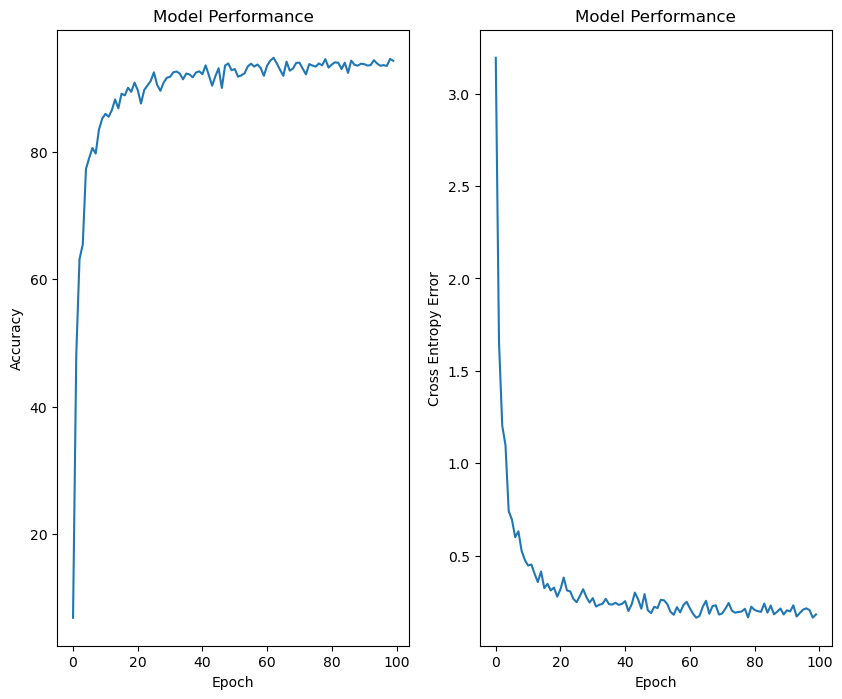

In [28]:
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.plot(np.arange(100),acc/len(labels_test)*100)
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(122)
plt.plot(np.arange(100),err/len(labels_test))
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Error')

# The result from 2 Layer Neural Network Seems very promising, yet we need to further investigate the precision for comparison with WEKA result and see whether it is close to those results or not.

In [42]:
# mean absolute error


import math
from sklearn.metrics import mean_squared_error
from math import sqrt


n = 20000
sum = 0
  
# for loop for iteration
for i in range(100):
    sum += abs(err[i])
  
error = sum/n
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : [5.04823839]


# Calculating the mean absolute error apparently tells us that although the training of the neural network seems very accurate yet the results are not even close to those from WEKA.

# Note the fluctuations in the Accuracy Plot, it seems that the accuracy of correctness is very high, but it is tricky here that the fluctuations affects the results significantly.

Yet, the results of this section and their inconsitency seems very confusing to me!!!